# CRICKET DATA ANALYSIS Using Selenium

## Step 1: Preparation of Datasets from the given link

In [1]:
from selenium import webdriver

In [2]:
from selenium.webdriver.chrome.service import Service

In [3]:
from selenium.webdriver.common.by import By

In [4]:
import time, os

In [5]:
# To setup the Chrome
# driver = webdriver.Chrome()
# driver.get("https://cricsheet.org/downloads/")

# formats = ['t20s', 'odis', 'tests']

# for fmt in formats:
#    link = driver.find_element(By.XPATH, '//a[@href="/downloads/all_json.zip"]')
#    link.click()
#    time.sleep(1200)

# driver.quit()

In [21]:
from selenium import webdriver
import time
import os

# STEP 1: Set your download folder
download_dir = os.path.join(os.getcwd(), "downloads")
os.makedirs(download_dir, exist_ok=True)

# STEP 2: Set Chrome options to allow automatic downloads
chrome_options = webdriver.ChromeOptions()
prefs = {
    "download.default_directory": download_dir,
    "download.prompt_for_download": False,
    "directory_upgrade": True
}
chrome_options.add_experimental_option("prefs", prefs)

# STEP 3: Start WebDriver
driver = webdriver.Chrome(options=chrome_options)

# STEP 4: Define the file download URLs
download_links = {
    'Tests': "https://cricsheet.org/downloads/tests_json.zip",
    'ODIs': "https://cricsheet.org/downloads/odis_json.zip",
    'T20s': "https://cricsheet.org/downloads/t20s_json.zip"
}

# STEP 5: Loop through and download each file
for match_type, url in download_links.items():
    print(f"Downloading {match_type} data...")
    driver.get(url)
    time.sleep(60)  # Wait for download to start

driver.quit()
print(f"\n All downloads completed. Files saved to: {download_dir}")



⬇️ Downloading Tests data...
⬇️ Downloading ODIs data...
⬇️ Downloading T20s data...

✅ All downloads completed. Files saved to: C:\Users\koushik\GUVI_DS\Cricdata_Analysis\downloads


## Step 2: Extract the downloaded JSON files

In [22]:
import os
import zipfile

# Source folder where the ZIP files were downloaded
download_dir = os.path.join(os.getcwd(), "downloads")

# Destination base folder
extract_base_dir = os.path.join(os.getcwd(), "data")
os.makedirs(extract_base_dir, exist_ok=True)

# Mapping of ZIP file names to folder names
zip_map = {
    "tests_json.zip": "Tests",
    "odis_json.zip": "ODIs",
    "t20s_json.zip": "T20s"
}

# Loop through each zip file and extract
for zip_file, folder_name in zip_map.items():
    zip_path = os.path.join(download_dir, zip_file)
    extract_path = os.path.join(extract_base_dir, folder_name)
    os.makedirs(extract_path, exist_ok=True)

    # Check if file exists
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
            print(f" Extracted '{zip_file}' to '{extract_path}'")
    else:
        print(f"❌ File not found: {zip_path}")

✅ Extracted 'tests_json.zip' to 'C:\Users\koushik\GUVI_DS\Cricdata_Analysis\data\Tests'
✅ Extracted 'odis_json.zip' to 'C:\Users\koushik\GUVI_DS\Cricdata_Analysis\data\ODIs'
✅ Extracted 't20s_json.zip' to 'C:\Users\koushik\GUVI_DS\Cricdata_Analysis\data\T20s'


In [29]:
import zipfile

download_dir = os.getcwd()
download_dir += "\\data"

#zip_path = os.path.join(download_dir, 'all_json.zip')
extract_path = os.path.join(download_dir, 'matches')

#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_path)

print(f"Extracted to {extract_path}")

Extracted to C:\Users\koushik\GUVI_DS\Cricdata_Analysis\data\matches


## STEP 3: Load all downloaded JSON Files into Database using SQLite

In [23]:
import os
import json
import sqlite3

# Set data folders
base_data_path = os.path.join(os.getcwd(), "data")
match_types = ['Tests', 'ODIs', 'T20s']

# Create SQLite DB
conn = sqlite3.connect("cricket_matches.db")
cursor = conn.cursor()

# Create matches table
cursor.execute("""
CREATE TABLE IF NOT EXISTS matches (
    match_id TEXT PRIMARY KEY,
    match_type TEXT,
    team1 TEXT,
    team2 TEXT,
    winner TEXT,
    result_type TEXT,
    result_value INTEGER,
    date TEXT,
    city TEXT
)
""")

# Loop through each match type folder
for match_type in match_types:
    folder = os.path.join(base_data_path, match_type)
    for filename in os.listdir(folder):
        if filename.endswith(".json"):
            match_id = filename.replace(".json", "")
            file_path = os.path.join(folder, filename)

            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)

            # Extract info safely
            info = data.get("info", {})
            teams = info.get("teams", ["N/A", "N/A"])
            outcome = info.get("outcome", {})
            city = info.get("city", "N/A")
            date = info.get("dates", ["N/A"])[0]

            # Winner, result type & value
            winner = outcome.get("winner", "draw" if "result" in outcome else "N/A")
            if "by" in outcome:
                result_type, result_value = list(outcome["by"].items())[0]
            else:
                result_type, result_value = "N/A", None

            # Insert into DB
            cursor.execute("""
            INSERT OR IGNORE INTO matches (match_id, match_type, team1, team2, winner, result_type, result_value, date, city)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
            """, (
                match_id,
                match_type,
                teams[0],
                teams[1],
                winner,
                result_type,
                result_value,
                date,
                city
            ))

# Commit and close
conn.commit()
conn.close()

print(" All match data loaded into cricket_matches.db")


✅ All match data loaded into cricket_matches.db


## STEP 4: EDA using pandas, matplotlib, seaborn, and plotly

### 4.1: Retrieve and Store the database tables into dataframe

In [25]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("cricket_matches.db")

# Load all match data into a DataFrame
df = pd.read_sql_query("SELECT * FROM matches", conn)

conn.close()

# Preview the data
print(df.head())
print("\nTotal Matches:", len(df))

  match_id match_type      team1         team2        winner result_type  \
0  1000851      Tests  Australia  South Africa  South Africa        runs   
1  1000853      Tests  Australia  South Africa  South Africa     innings   
2  1000855      Tests  Australia  South Africa     Australia     wickets   
3  1000881      Tests  Australia      Pakistan     Australia        runs   
4  1000883      Tests  Australia      Pakistan     Australia     innings   

   result_value        date      city  
0         177.0  2016-11-03     Perth  
1           1.0  2016-11-12    Hobart  
2           7.0  2016-11-24       N/A  
3          39.0  2016-12-15  Brisbane  
4           1.0  2016-12-26       N/A  

✅ Total Matches: 8191


### 4.2: Check the missing values and datatypes

In [28]:
print("\n🔍 Missing Values:\n", df.isnull().sum())
print("\n📦 Data Types:\n", df.dtypes)


🔍 Missing Values:
 match_id          0
match_type        0
team1             0
team2             0
winner            0
result_type       0
result_value    450
date              0
city              0
dtype: int64

📦 Data Types:
 match_id         object
match_type       object
team1            object
team2            object
winner           object
result_type      object
result_value    float64
date             object
city             object
dtype: object


### 4.3: Number of matches in Bar Chart

C:\Users\koushik\AppData\Local\Temp\ipykernel_11512\1724064502.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='match_type', data=df, palette="pastel")


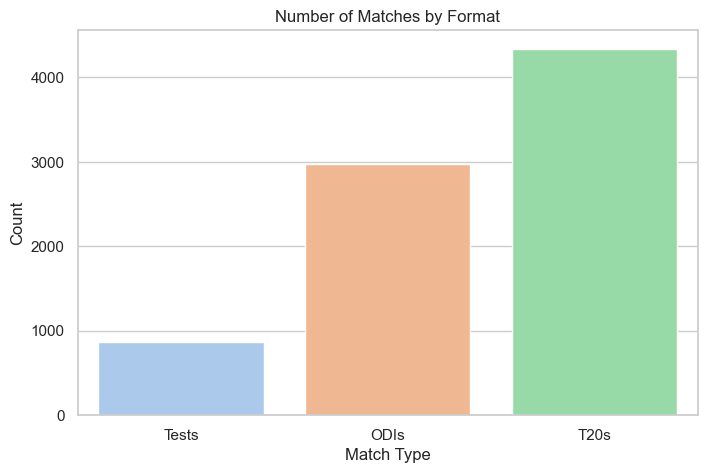

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(x='match_type', data=df, palette="pastel")
plt.title("Number of Matches by Format")
plt.xlabel("Match Type")
plt.ylabel("Count")
plt.show()


### 4.4: Top 10 Cities with most matches

C:\Users\koushik\AppData\Local\Temp\ipykernel_11512\3807112295.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_counts.values, y=city_counts.index, palette="viridis")


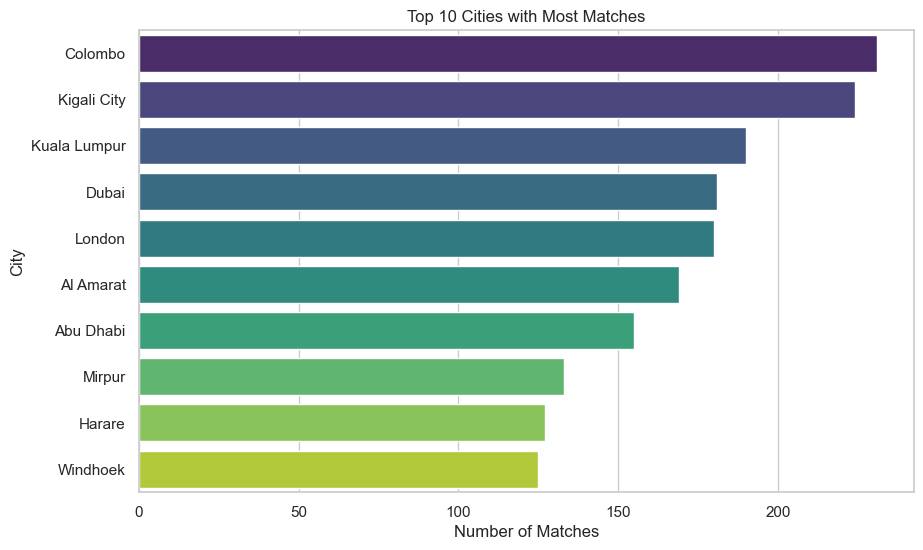

In [31]:
plt.figure(figsize=(10, 6))
filtered_df = df[df['city'].notna() & (df['city'] != 'N/A')]
city_counts = filtered_df['city'].value_counts().head(10)
sns.barplot(x=city_counts.values, y=city_counts.index, palette="viridis")
plt.title("Top 10 Cities with Most Matches")
plt.xlabel("Number of Matches")
plt.ylabel("City")
plt.show()


### 4.5: Match result type Distribution

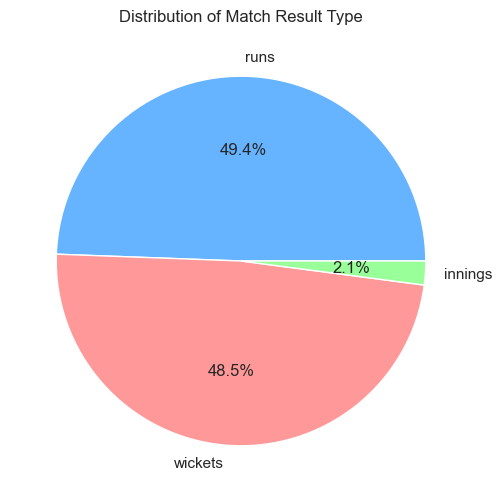

In [34]:
plt.figure(figsize=(6, 6))
filtered_df = df[df['result_type'].notna() & (df['result_type'] != 'N/A')]
filtered_df['result_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff','#ff9999','#99ff99'])
plt.title("Distribution of Match Result Type")
plt.ylabel("")
plt.show()


### 4.6 Most successful Teams (Top 10 Wins)

C:\Users\koushik\AppData\Local\Temp\ipykernel_11512\1701512147.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_winners.values, y=top_winners.index, palette="magma")


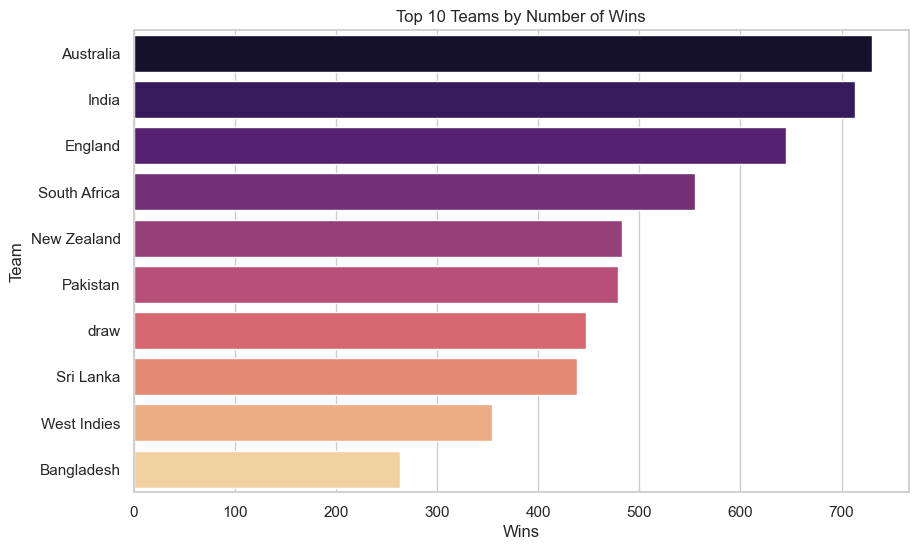

In [35]:
plt.figure(figsize=(10, 6))
top_winners = df['winner'].value_counts().head(10)
sns.barplot(x=top_winners.values, y=top_winners.index, palette="magma")
plt.title("Top 10 Teams by Number of Wins")
plt.xlabel("Wins")
plt.ylabel("Team")
plt.show()


### 4.7: Matches Over Time (Time Series)

C:\Users\koushik\AppData\Local\Temp\ipykernel_11512\298706330.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='year', order=sorted(df['year'].dropna().unique()), palette="coolwarm")


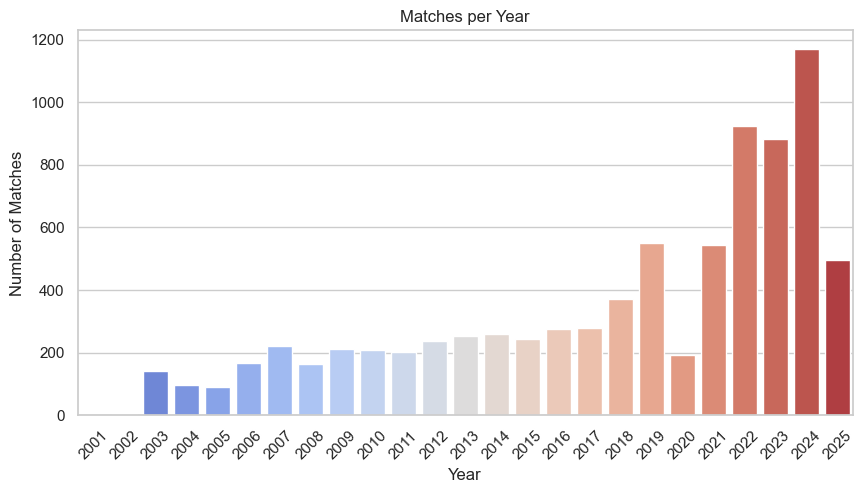

In [37]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='year', order=sorted(df['year'].dropna().unique()), palette="coolwarm")
plt.title("Matches per Year")
plt.xlabel("Year")
plt.ylabel("Number of Matches")
plt.xticks(rotation=45)
plt.show()


### 4.8: Number of Matches by Format using interactive Bar chart 

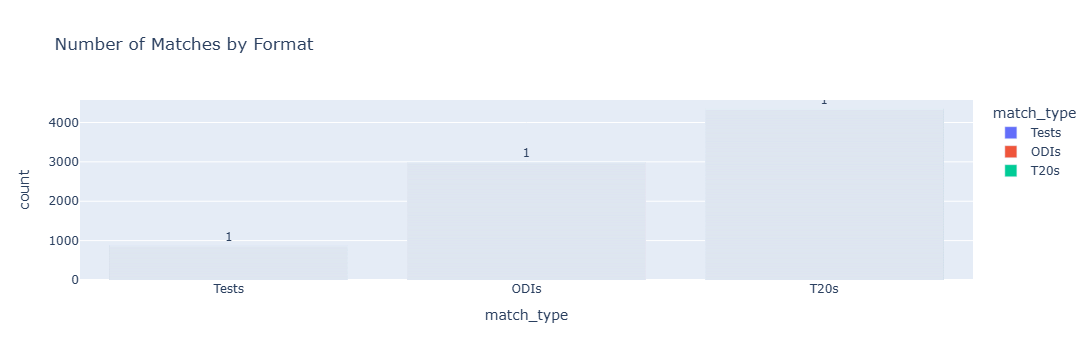

In [40]:
import plotly.express as px

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year
fig = px.bar(df, x='match_type', title="Number of Matches by Format",
             color='match_type', text_auto=True)
fig.show()

### 4.9: Match Result Type using interactive Pie Chart

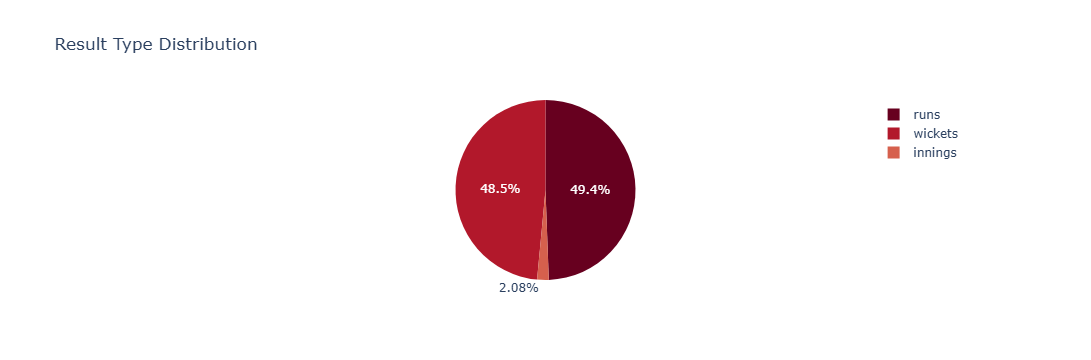

In [42]:
filtered_df = df[df['result_type'].notna() & (df['result_type'] != 'N/A')]
fig = px.pie(filtered_df, names='result_type', title="Result Type Distribution",
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

### 4.10: Top 10 Cities Hosting Most Matches using ineractive chart

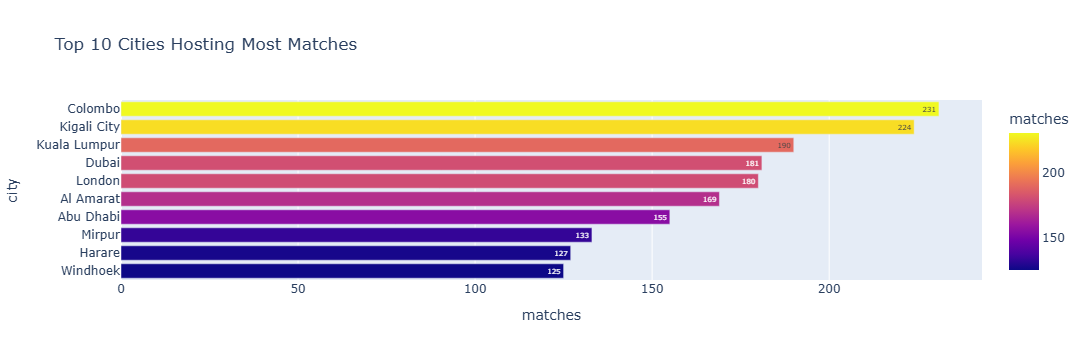

In [45]:
filtered_df = df[df['city'].notna() & (df['city'] != 'N/A')]

city_counts = filtered_df['city'].value_counts().head(10).reset_index()
city_counts.columns = ['city', 'matches']

fig = px.bar(city_counts, x='matches', y='city',
             orientation='h',
             title="Top 10 Cities Hosting Most Matches",
             color='matches', text='matches')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


### 4.11: Top 10 Winning Teams using interactive chart

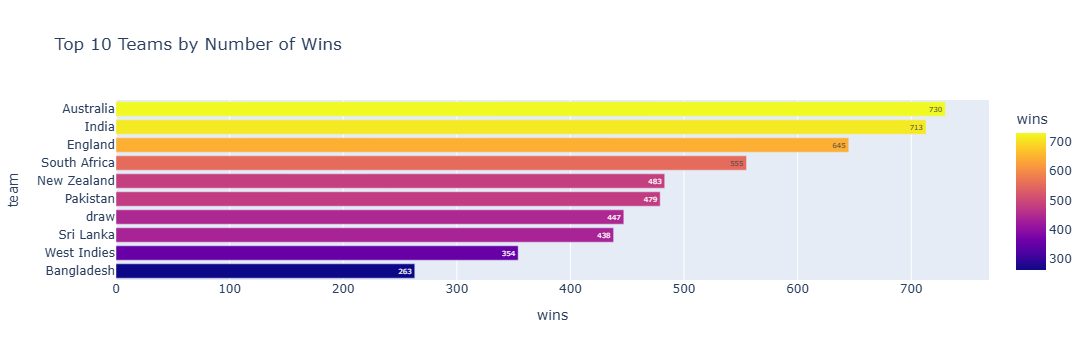

In [47]:
winner_counts = df['winner'].value_counts().head(10).reset_index()
winner_counts.columns = ['team', 'wins']

fig = px.bar(winner_counts, x='wins', y='team',
             orientation='h',
             title="Top 10 Teams by Number of Wins",
             color='wins', text='wins')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


### 4.12: Matches Played over the year

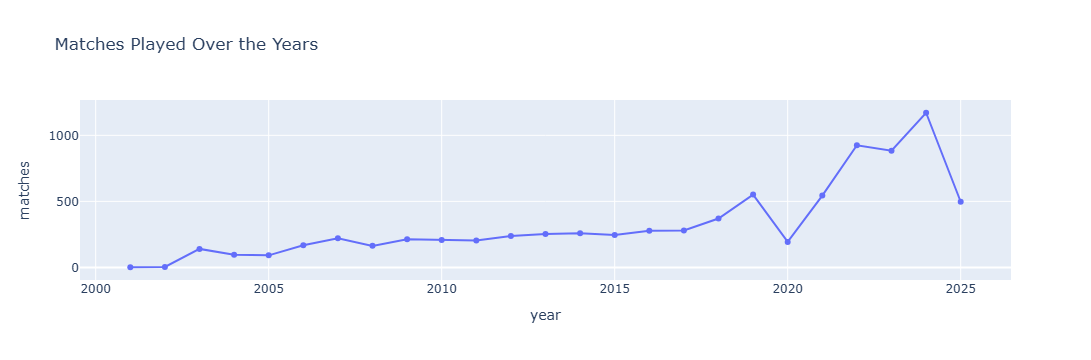

In [48]:
yearly_matches = df['year'].value_counts().sort_index().reset_index()
yearly_matches.columns = ['year', 'matches']

fig = px.line(yearly_matches, x='year', y='matches',
              title="Matches Played Over the Years",
              markers=True)
fig.show()


## STEP 5: Creating a Dashboard using Power BI

### 5.1: Generating the datasets

In [49]:
import sqlite3
import pandas as pd

# Connect to DB
conn = sqlite3.connect("cricket_matches.db")

# Read table
df = pd.read_sql_query("SELECT * FROM matches", conn)

# Export to CSV
df.to_csv("matches.csv", index=False)
conn.close()

print("Exported to matches.csv")


✅ Exported to matches.csv


In [50]:
df

,match_id,match_type,team1,team2,winner,result_type,result_value,date,city
0,1000851,Tests,Australia,South Africa,South Africa,runs,177.0,2016-11-03,Perth
1,1000853,Tests,Australia,South Africa,South Africa,innings,1.0,2016-11-12,Hobart
2,1000855,Tests,Australia,South Africa,Australia,wickets,7.0,2016-11-24,N/A
3,1000881,Tests,Australia,Pakistan,Australia,runs,39.0,2016-12-15,Brisbane
4,1000883,Tests,Australia,Pakistan,Australia,innings,1.0,2016-12-26,N/A
...,...,...,...,...,...,...,...,...,...
8186,966763,T20s,Pakistan,Sri Lanka,Pakistan,wickets,6.0,2016-03-04,Mirpur
8187,966765,T20s,Bangladesh,India,India,wickets,8.0,2016-03-06,Mirpur
8188,967081,T20s,United Arab Emirates,Netherlands,Netherlands,runs,84.0,2016-02-03,Dubai
8189,995467,T20s,Sri Lanka,Australia,Australia,runs,85.0,2016-09-06,N/A


### The same above EDA Analysis. Continued wing Power BI